In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplcyberpunk

plt.style.use("cyberpunk")
from scipy.stats import norm

# Bias and Variance Decomposition

In [2]:
x = np.arange(-10, 10, 0.0001)
bayes_model = norm.pdf(x, loc=-3, scale=1)
hypothesis = norm.pdf(x, loc=3, scale=1.8)

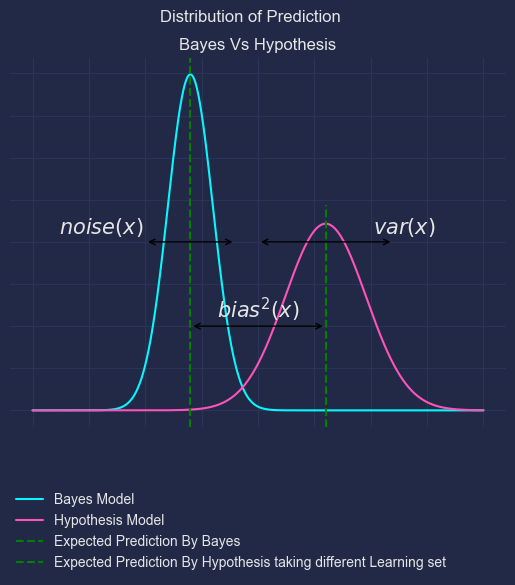

In [3]:
plt.suptitle("Distribution of Prediction")
plt.title("Bayes Vs Hypothesis")
plt.plot(x, bayes_model, label="Bayes Model")
plt.plot(x, hypothesis, label="Hypothesis Model")
plt.axvline(x=-3, linestyle="--", c="g", label="Expected Prediction By Bayes")
plt.axvline(x=3, ymax=0.6, linestyle="--", c="g",
            label="Expected Prediction By Hypothesis taking different Learning set")

plt.text(0, 0.11, r"$bias^2(x)$", fontsize=15, horizontalalignment='center')
plt.annotate(
    '', xy=(-3, 0.1), xycoords='data',
    xytext=(3, 0.1), textcoords='data',
    arrowprops={'arrowstyle': '<->'})

plt.text(-5.1, 0.21, r"$noise(x)$", fontsize=15, horizontalalignment='right')
plt.annotate(
    '', xy=(-5, 0.2), xycoords='data',
    xytext=(-1, 0.2), textcoords='data',
    arrowprops={'arrowstyle': '<->'})

plt.text(5.1, 0.21, r"$var(x)$", fontsize=15, horizontalalignment='left')
plt.annotate(
    '', xy=(6, 0.2), xycoords='data',
    xytext=(0, 0.2), textcoords='data',
    arrowprops={'arrowstyle': '<->'})

plt.gca().spines[["top", "right", "left", "bottom"]].set_visible(False)
plt.gca().tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)

plt.legend(loc=(0, -0.4))
plt.show()

# Understanding the UnderFitting and OverFitting

In [26]:
import numpy as np
import matplotlib.pyplot as plt

blue = (0, 0, 1.0)
green = (0, 0.8, 0)
red = (1.0, 0, 0)
red_alpha = (1.0, 0, 0, 0.001)
gray = (0.7, 0.7, 0.7)

# Settings
n_repeat = 100  # Number of iterations for computing expectations
n_train = 30  # Size of the training set
n_test = 1000  # Size of the test set
noise = 0.1 ** 0.5  # Standard deviation of the noise
np.random.seed(0)

In [27]:

# Generate data
def f(x):
    x = x.ravel()

    return np.cos(2.5 * np.pi * x)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples)
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

estimators = [("Degree = 1", Pipeline([("polynomial_features", PolynomialFeatures(degree=1, include_bias=False)),
                                       ("linear_regression", LinearRegression())])),
              ("Degree = 5", Pipeline([("polynomial_features", PolynomialFeatures(degree=5, include_bias=False)),
                                       ("linear_regression", LinearRegression())])),
              ("Degree = 15", Pipeline([("polynomial_features", PolynomialFeatures(degree=15, include_bias=False)),
                                        ("linear_regression", LinearRegression())])), ]

n_estimators = len(estimators)

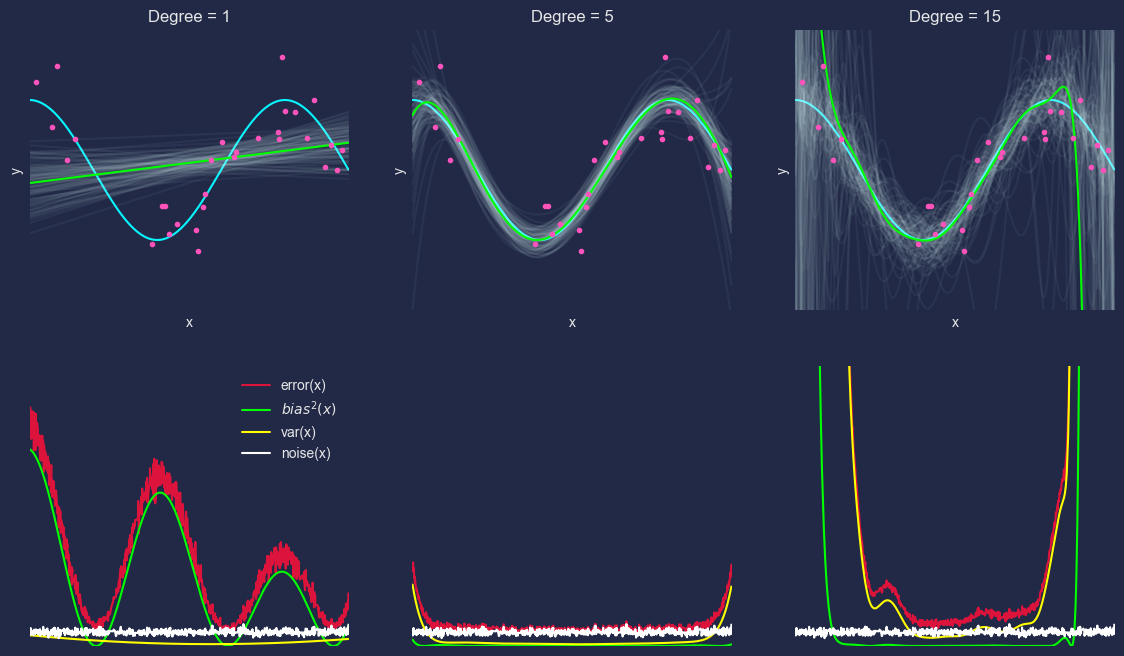

In [31]:
plt.figure(figsize=(14, 8))
for n, (name, estimator) in enumerate(estimators):
    # making the prediction for different Learning set
    y_predict = np.zeros((n_test, n_repeat))
    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # find the error from true value and predict value
    y_error = np.zeros(n_test)
    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    # bias - variance decomposition
    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    ax = plt.subplot(2, n_estimators, n + 1)
    plt.setp(ax, xticks=(), yticks=(),xlim=(0,1.0),ylim=(-2,2),xlabel="x",ylabel="y",title=name)
    plt.plot(X_test, f(X_test))
    plt.plot(X_train[0], y_train[0], ".",zorder=2.5)
    for idx in range(n_repeat):
        plt.plot(X_test, y_predict[:, idx], c="lightcyan", alpha=0.05)
    plt.plot(X_test, np.mean(y_predict, axis=1), c="lime")


    ax = plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.setp(ax, xticks=(), yticks=(),ylim=(0,2),xlim=(0,1.0))
    plt.plot(X_test, y_error, color="crimson", label="error(x)")
    plt.plot(X_test, y_bias, color="lime", label="$bias^2(x)$")
    plt.plot(X_test, y_var, color="yellow", label="var(x)")
    plt.plot(X_test, y_noise, color="white", label="noise(x)")

    if n == 0:
        plt.legend()

$$=\frac{1}{M^2}\left[\mathbb{E}_{\mathcal{L}, \theta_1, \ldots, \theta_M}\left\{\sum_{i, j} \varphi_{\mathcal{L}, \theta_i}(\mathbf{x}) \varphi_{\mathcal{L}, \theta_j}(\mathbf{x})\right\}-\left(M_{\mu_{\mathcal{L}, \theta}}(\mathbf{x})\right)^2\right]$$

This expression appears to be a measure of uncertainty or variability in a model with parameters $\theta$. The first term inside the square brackets is an expectation over different parameter settings, indicating that this term is a measure of the average behavior of the model. The second term is the square of the mean function of the model, which represents the average behavior of the model under a single set of parameters. The difference between these two terms, divided by the square of the number of parameters $M$, is a measure of how much the model's behavior varies from its average behavior

$$=\frac{1}{M^2}\left[\sum_{i, j} \mathbb{E}_{\mathcal{L}, \theta_i, \theta_j}\left\{\varphi_{\mathcal{L}, \theta_i}(\mathbf{x}) \varphi_{\mathcal{L}, \theta_j}(\mathbf{x})\right\}-M^2 \mu_{\mathcal{L}, \theta}^2(\mathbf{x})\right] $$

This expression is similar to the previous one, but the order of the summation and expectation has been reversed. Here, the expectation is taken over pairs of parameter settings, indicating that this term is a measure of the average behavior of the model under different pairs of parameters. The difference between this term and the square of the mean function is still a measure of how much the model's behavior varies from its average behavior. This expression is equivalent to the previous one, but the interpretation of the individual terms is slightly different.

$$\begin {aligned} &
=\frac{1}{M^2}\left[M \mathbb{E}_{\mathcal{L}, \theta}\left\{\varphi_{\mathcal{L}, \theta}(\mathbf{x})^2\right\}\right. \\
& \left.\hookrightarrow+\left(M^2-M\right) \mathbb{E}_{\mathcal{L}, \theta^{\prime}, \theta^{\prime \prime}}\left\{\varphi_{\mathcal{L}, \theta^{\prime}}(\mathbf{x}) \varphi_{\mathcal{L}, \theta^{\prime \prime}}(\mathbf{x})\right\}-M^2 \mu_{\mathcal{L}, \theta}^2(\mathbf{x})\right]
\end{aligned}$$

This expression is similar to the previous ones, but it has been simplified by applying the identity $\sum_{i, j} a_{i, j} = \sum_{i} a_{i, i} + \sum_{i \neq j} a_{i, j}$. This identity has been used to split the double summation in the first term of the expression into two separate summations: one over the diagonal elements (where $i = j$) and one over the off-diagonal elements (where $i \neq j$). The diagonal summation is equal to the mean of the squares of the model's outputs, and the off-diagonal summation is equal to the average product of the model's outputs under different pairs of parameters. This expression is still a measure of how much the model's behavior varies from its average behavior, but the individual terms have a slightly different interpretation.